# Prep

In [5]:
import tensorflow as tf
import os
import numpy as np

image_dimensions = (512, 512)
dataset_percent = 50
batch_size = 8

# Important!
include_other_class = True
grayscale = True

if include_other_class:
  num_classes = 6
else:
  num_classes = 5

training_presets_subfolder_name = f'6_class/{str(image_dimensions[0])}_{str(dataset_percent)}_6_class'
if include_other_class is True:
  encoder_filepath = f"./datasets/{training_presets_subfolder_name}/encoder.pkl"
  model_filepath = f'./models/6_class/fastener_net_6_{str(image_dimensions[0])}_{str(dataset_percent)}.keras'
  model_results_folder = f'./model_results/{str(image_dimensions[0])}_{str(dataset_percent)}_6_class'
  model_results_filepath = f'{model_results_folder}/results.md'
else:
  encoder_filepath = f"./datasets/{training_presets_subfolder_name}/encoder_NO_OTHER.pkl"
  model_filepath = f'./models/6_class/fastener_net_6_{str(image_dimensions[0])}_{str(dataset_percent)}_NO_OTHER.keras'
  model_results_folder = f'./model_results/{str(image_dimensions[0])}_{str(dataset_percent)}_6_class'
  model_results_filepath = f'{model_results_folder}/results_NO_OTHER.md'

if grayscale is True:
  model_filepath = f'./models/6_class/fastener_net_6_{str(image_dimensions[0])}_{str(dataset_percent)}_grayscale.keras'

print(training_presets_subfolder_name)

6_class/512_50_6_class


# Prepare Data

In [6]:
import pickle

if include_other_class is False:
  training_set_file_path = f"./datasets/{training_presets_subfolder_name}/training_set_NO_OTHER.pkl"
  validation_set_file_path = f"./datasets/{training_presets_subfolder_name}/validation_set_NO_OTHER.pkl"
  test_set_file_path = f"./datasets/{training_presets_subfolder_name}/test_set_NO_OTHER.pkl"
else:
  training_set_file_path = f"./datasets/{training_presets_subfolder_name}/training_set.pkl"
  validation_set_file_path = f"./datasets/{training_presets_subfolder_name}/validation_set.pkl"
  test_set_file_path = f"./datasets/{training_presets_subfolder_name}/test_set.pkl"

if grayscale is True:
  training_set_file_path = f"./datasets/{training_presets_subfolder_name}/training_set_grayscale.pkl"
  validation_set_file_path = f"./datasets/{training_presets_subfolder_name}/validation_set_grayscale.pkl"
  test_set_file_path = f"./datasets/{training_presets_subfolder_name}/test_set_grayscale.pkl"

with open(training_set_file_path, "rb") as file:
  print('Loading training set...')
  train_set = pickle.load(file)
  print('Done!')
  
with open(validation_set_file_path, "rb") as file:
  print('Loading validation set...')
  validation_set = pickle.load(file)
  print('Done!')
  
with open(test_set_file_path, "rb") as file:
  print('Loading test set...')
  test_set = pickle.load(file)
  print('Done!')

print(set([t[1] for t in train_set]))

Loading training set...
Done!
Loading validation set...
Done!
Loading test set...
Done!
{0, 1, 2, 3, 4, 5}


In [7]:
(test_images, test_labels) = zip(*test_set)

test_images = np.array(test_images)
test_labels = np.array([int(label) for label in test_labels])

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

print(len(test_dataset))

83


##### Optional: View

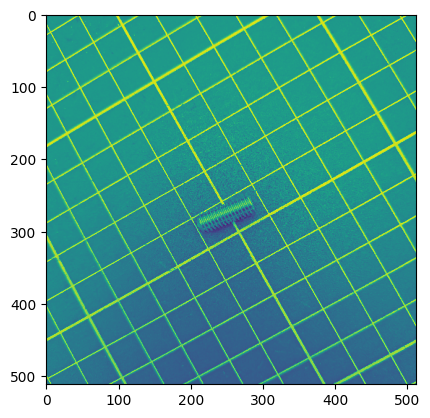

In [4]:
import matplotlib.pyplot as plt

for i in test_set[:20]:
    if i[1] == 5:
        plt.imshow(i[0].astype(np.short)); plt.show()

# Inference

### Initial Results

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
import gc

gc.collect() 
keras.backend.clear_session()

test_model = keras.models.load_model(model_filepath)
evaluation_results = test_model.evaluate(test_dataset)
print(f"Test accuracy: {evaluation_results[1]:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7796 - loss: 0.6605
Test accuracy: 0.7697


In [7]:
pred = test_model.predict(test_dataset)
pred_labels = np.argmax(pred, axis=1)

test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


2024-06-13 13:05:03.175039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Conf Matrix

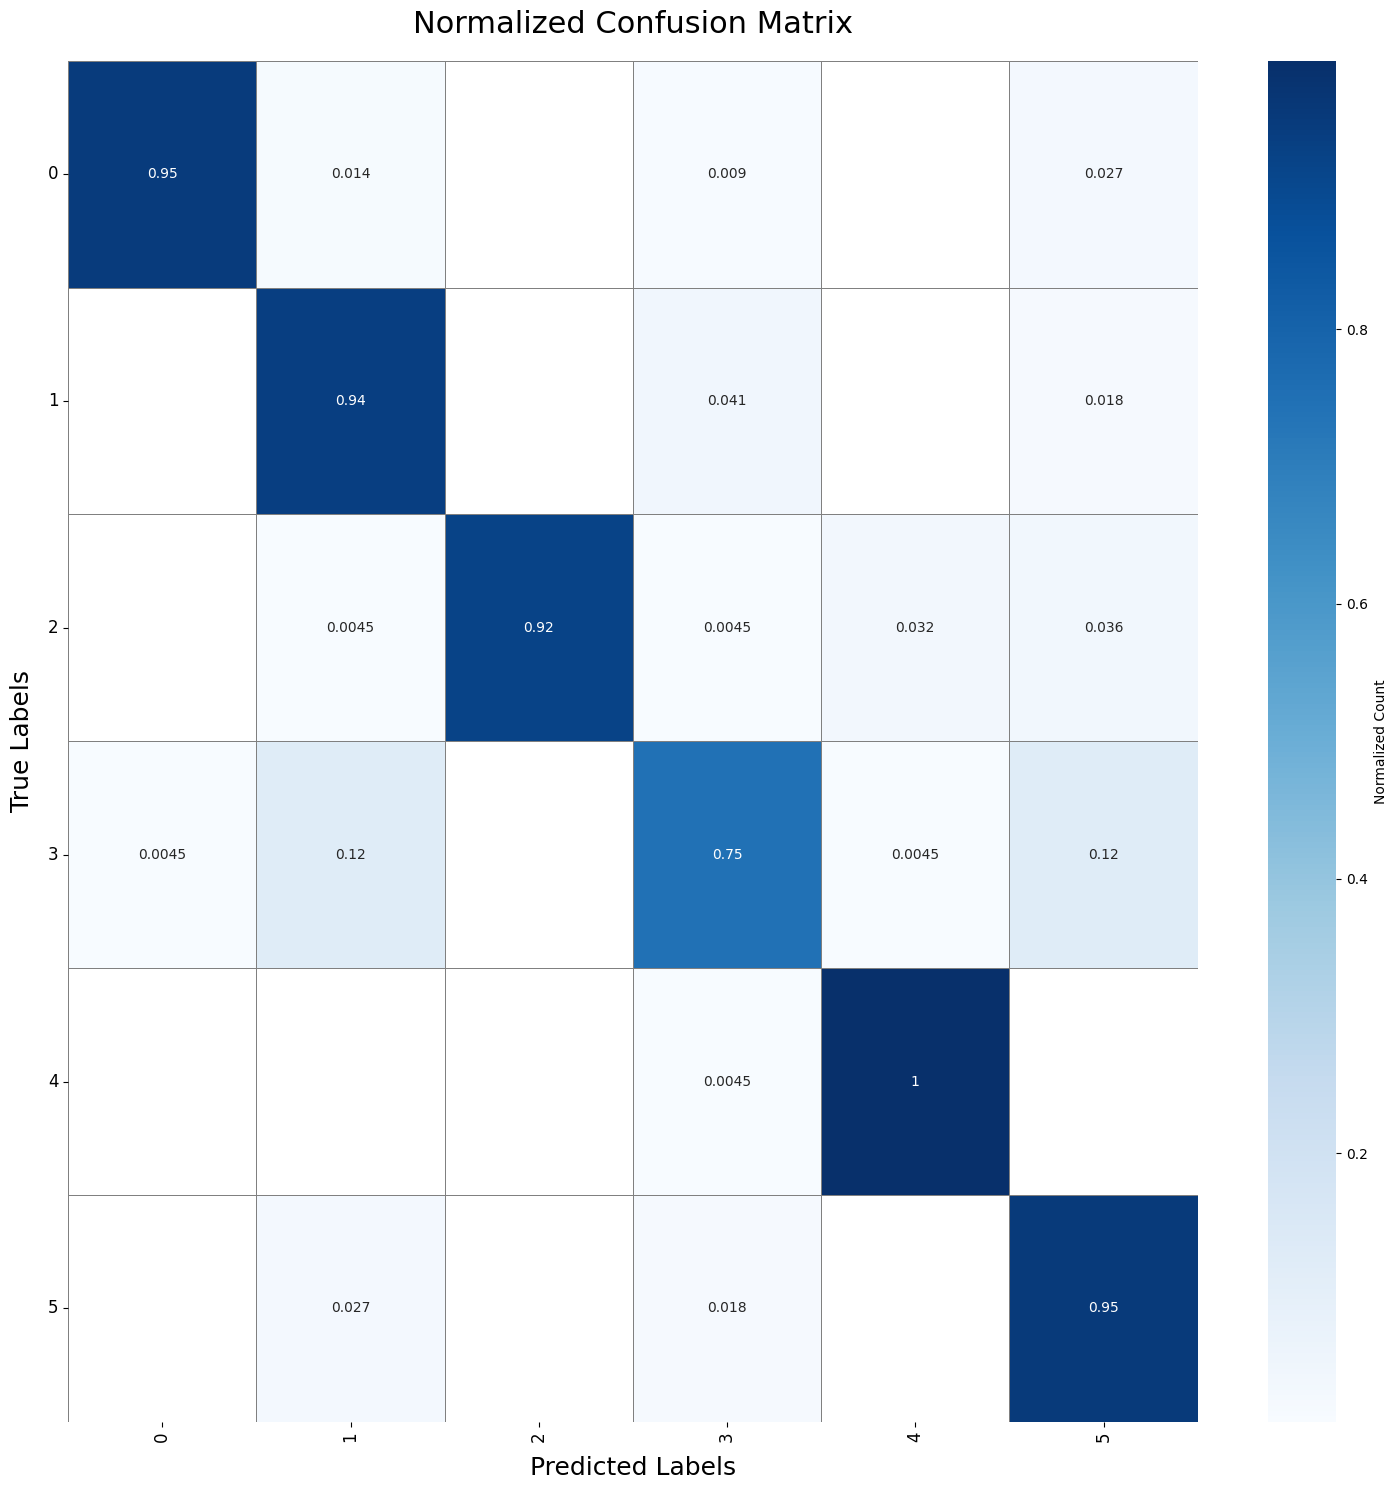

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a mask for zero values to color them white
mask = cm_normalized == 0

# Plotting the normalized confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=range(6), yticklabels=range(6),
            cbar_kws={'label': 'Normalized Count'}, mask=mask, linewidths=0.5, linecolor='grey', annot_kws={"size": 10})
plt.xlabel('Predicted Labels', fontsize=18, labelpad=10)
plt.ylabel('True Labels', fontsize=18, labelpad=10)
plt.title('Normalized Confusion Matrix', fontsize=22, pad=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig(f'{model_results_folder}/conf_matrix.png', dpi=300)
plt.show()

### Salience Map

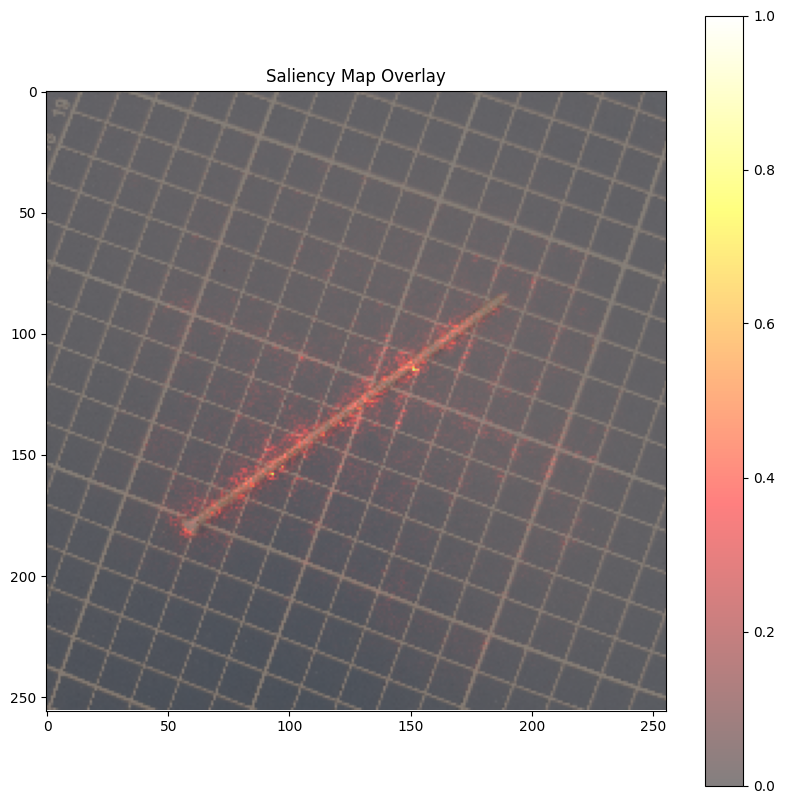

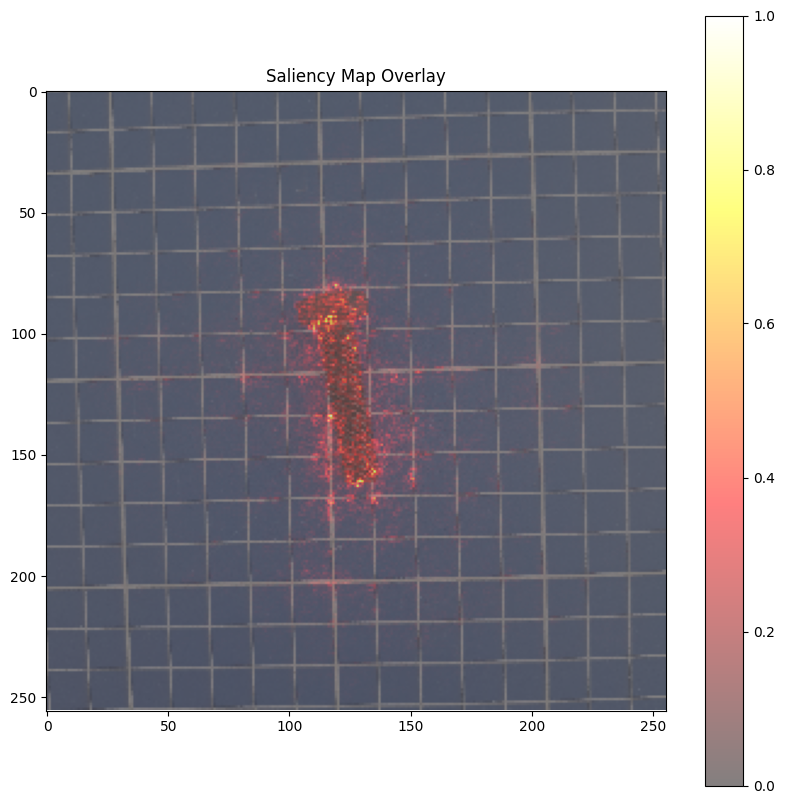

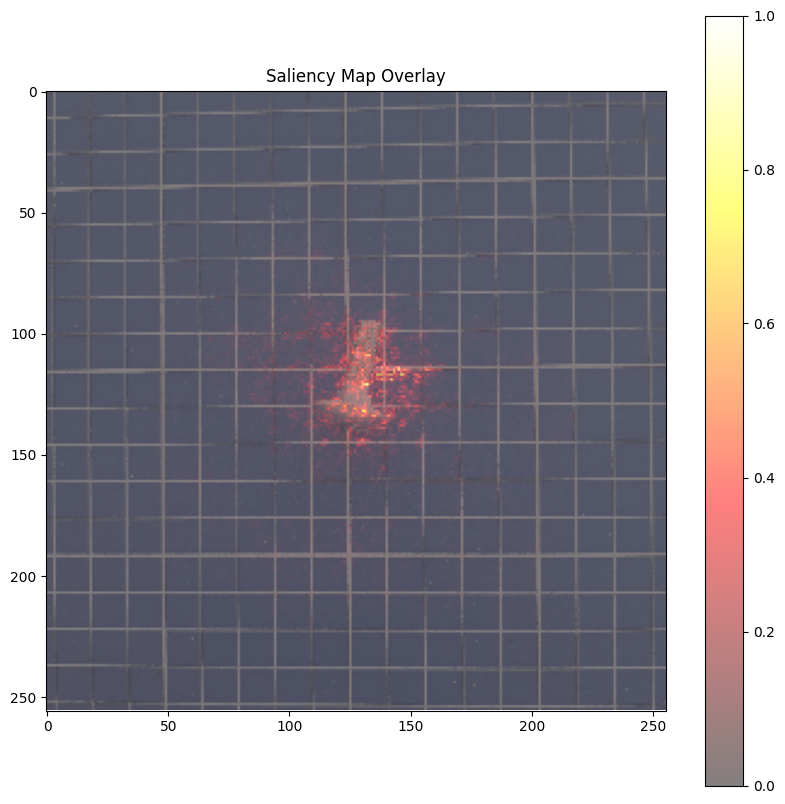

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

for j in range(3):
    index = random.randint(0, len(test_images) - 1)
    test_image = test_images[index].astype(np.short)

    def get_saliency_map(model, img):
        img = tf.convert_to_tensor(img, dtype=tf.float32)
        img = tf.expand_dims(img, axis=0)  # Ensure the image is batched

        with tf.GradientTape() as tape:
            tape.watch(img)
            preds = model(img, training=False)
            top_class = tf.argmax(preds[0])
            top_class_score = preds[:, top_class]

        grads = tape.gradient(top_class_score, img)
        if grads is None:
            raise ValueError("Gradients computation returned None. Check if the model and input are set up correctly.")
        
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]  
        saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))  

        return saliency.numpy()

    # Example usage with a single test image
    saliency_map = get_saliency_map(test_model, test_image)

    plt.figure(figsize=(10, 10))
    plt.imshow(test_image, cmap='gray', alpha=0.5)  
    plt.imshow(saliency_map, cmap='hot', alpha=0.5)  
    plt.colorbar()
    plt.title('Saliency Map Overlay')
    plt.show()